<a href="https://colab.research.google.com/github/nivasu06/scene_prediction/blob/main/Microproject1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
!pip install torch torchvision numpy matplotlib kaggle

In [71]:
# Install required libraries (if not already installed)
!pip install torch torchvision numpy matplotlib

# Setup Kaggle API to download dataset (Replace with your Kaggle API key)
!mkdir ~/.kaggle
!echo '{"username":"rnivasu","key":"fe069dcca6143341cee7e2c1da944b47"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d puneet6060/intel-image-classification

# Unzip dataset
!unzip -q intel-image-classification.zip


mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 99% 344M/346M [00:04<00:00, 94.3MB/s]
100% 346M/346M [00:04<00:00, 80.8MB/s]


In [72]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image


In [73]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [74]:
# Define dataset paths
train_path = "seg_train/seg_train"
test_path = "seg_test/seg_test"

# Load dataset
full_train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
full_test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# Select only a subset (e.g., 20% of the data)
subset_train_indices = np.random.choice(len(full_train_dataset), size=int(0.2 * len(full_train_dataset)), replace=False)
subset_test_indices = np.random.choice(len(full_test_dataset), size=int(0.2 * len(full_test_dataset)), replace=False)

# Create subset datasets
train_dataset = Subset(full_train_dataset, subset_train_indices)
test_dataset = Subset(full_test_dataset, subset_test_indices)

# Load data into DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes
print(f"Train Dataset Size: {len(train_dataset)} images")
print(f"Test Dataset Size: {len(test_dataset)} images")


Train Dataset Size: 2806 images
Test Dataset Size: 600 images


In [75]:
import torch.nn as nn
import torch.optim as optim

# Define CNN architecture
class SceneClassifierCNN(nn.Module):
    def __init__(self):
        super(SceneClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 37 * 37, 128)  # Adjust according to image size after pooling
        self.fc2 = nn.Linear(128, 6)  # 6 classes (Buildings, Forest, Glacier, Mountain, Sea, Street)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)  # Flatten for Fully Connected layers
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SceneClassifierCNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [76]:
num_epochs = 5  # Reduced epochs for faster training

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

print("Training complete!")


Epoch 1, Loss: 1.642024116082625
Epoch 2, Loss: 1.4826749468391591
Epoch 3, Loss: 1.3910359794443303
Epoch 4, Loss: 1.3568913205103441
Epoch 5, Loss: 1.3244598047299818
Training complete!


In [77]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 69.17%


In [78]:
import os

# Check if the test dataset folder exists
test_folder = "seg_test/seg_test"
if os.path.exists(test_folder):
    print("Test folder found!")
    print("Available categories:", os.listdir(test_folder))
else:
    print("Test folder NOT found! Check if the dataset was extracted correctly.")


Test folder found!
Available categories: ['street', 'mountain', 'buildings', 'glacier', 'forest', 'sea']


In [79]:
mountain_folder = "seg_test/seg_test/mountain"
if os.path.exists(mountain_folder):
    print("Mountain folder found!")
    print("Available images:", os.listdir(mountain_folder)[:5])  # Show first 5 images
else:
    print("Mountain folder NOT found! Check dataset extraction.")


Mountain folder found!
Available images: ['23018.jpg', '23451.jpg', '21665.jpg', '22958.jpg', '21893.jpg']


In [80]:
# Pick an available image dynamically
available_images = os.listdir(mountain_folder)
if len(available_images) > 0:
    test_image_path = os.path.join(mountain_folder, available_images[10])
    print("Using image:", test_image_path)
else:
    print("No images found in mountain folder!")


Using image: seg_test/seg_test/mountain/23312.jpg


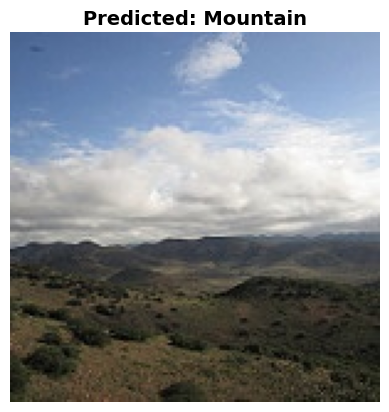

'Mountain'

In [81]:
predict_image(test_image_path, model)


Using image: seg_test/seg_test/mountain/23018.jpg


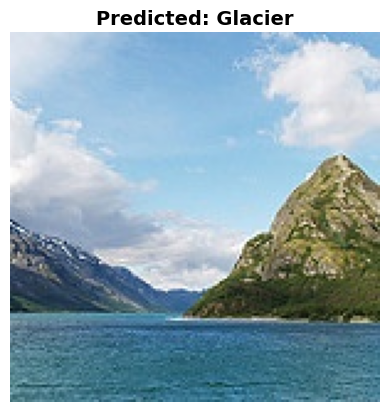

'Glacier'

In [82]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Class labels
class_labels = ["Buildings", "Forest", "Glacier", "Mountain", "Sea", "Street"]

# Function to predict and display an image
def predict_image(image_path, model):
    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)  # Get probabilities
        predicted_class = torch.argmax(probabilities, dim=1).item()

    # Display Image and Prediction
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title(f"Predicted: {class_labels[predicted_class]}", fontsize=14, fontweight='bold')
    plt.show()

    return class_labels[predicted_class]

# --- Fixing test_image_path ---
test_folder = "seg_test/seg_test/mountain"

# Check if the folder exists and has images
if os.path.exists(test_folder) and len(os.listdir(test_folder)) > 0:
    test_image_path = os.path.join(test_folder, os.listdir(test_folder)[0])  # Pick first image
    print(f"Using image: {test_image_path}")
else:
    raise FileNotFoundError("No images found in the 'mountain' folder!")

# Predict and display
predict_image(test_image_path, model)


Enter the image path: /content/Iron-Man-3-New-ipad.jpg
Processing image: /content/Iron-Man-3-New-ipad.jpg


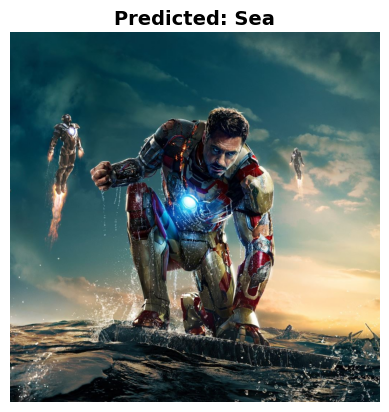

In [83]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Class labels
class_labels = ["Buildings", "Forest", "Glacier", "Mountain", "Sea", "Street"]

# Function to predict and display an image
def predict_image(image_path, model):
    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)  # Get probabilities
        predicted_class = torch.argmax(probabilities, dim=1).item()

    # Display Image and Prediction
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title(f"Predicted: {class_labels[predicted_class]}", fontsize=14, fontweight='bold')
    plt.show()

    return class_labels[predicted_class]

# --- User Inputs Image Path ---
image_path = input("Enter the image path: ").strip()

# Validate if the file exists
if os.path.exists(image_path):
    print(f"Processing image: {image_path}")
    predict_image(image_path, model)
else:
    print("Error: The file does not exist. Please enter a valid image path.")


Saving 1638235.jpg to 1638235 (1).jpg
Saving th.jpeg to th.jpeg

Processing image: 1638235 (1).jpg


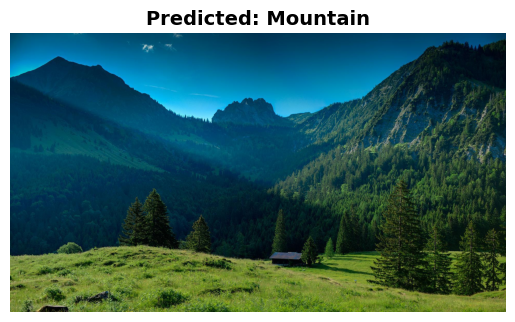


Processing image: th.jpeg


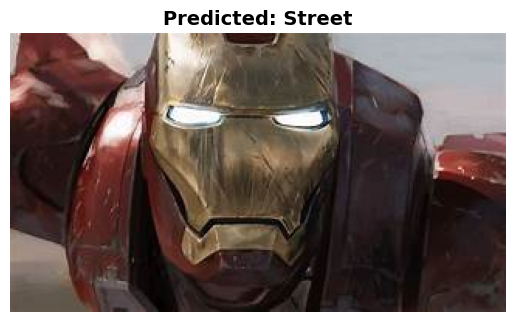

In [105]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files  # For file upload in Google Colab

# Class labels
class_labels = ["Buildings", "Forest", "Glacier", "Mountain", "Sea", "Street"]

# Function to predict and display an image
def predict_image(image_path, model):
    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)  # Get probabilities
        predicted_class = torch.argmax(probabilities, dim=1).item()

    # Display Image and Prediction
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title(f"Predicted: {class_labels[predicted_class]}", fontsize=14, fontweight='bold')
    plt.show()

    return class_labels[predicted_class]

# --- User Uploads Multiple Images ---
uploaded_files = files.upload()  # Allows multiple file uploads

# Create a directory to store images
os.makedirs("images", exist_ok=True)

# Process each uploaded image
for filename in uploaded_files.keys():
    image_path = os.path.join("images", filename)  # Save path
    with open(image_path, "wb") as f:
        f.write(uploaded_files[filename])  # Save image

    print(f"\nProcessing image: {filename}")
    predict_image(image_path, model)  # Predict for each image
